# 線形次元削減

「ベイズ推論による機械学習入門」p.161~を参照．

In [1]:
!date

2019年 8月28日 水曜日 21時04分44秒 JST


In [13]:
%matplotlib inline

import warnings
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.special import logsumexp
from numpy.random import multivariate_normal, randn, rand

from sklearn.datasets import load_iris, fetch_olivetti_faces

warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')
plt.rcParams['image.cmap'] = 'viridis'
sns.set_context('talk')

# Model

In [90]:
class LinearDimensionalityReduction:
    """
    Linear Dimensionality Reduction
    
    p(Y, X, W, mu) = p(Y|X, W, mu)p(X)p(W)p(mu)
    
    p(y_n|x_n, W, mu) = N(y_n|W'x_n + mu, sigma_y*I)
    p(x_n) = N(x_n|0, I)
    p(w_d) = N(w_d|0, sigma_w)
    p(mu) = N(mu|0, sigma_mu)
    """
    
    def __init__(self, d=2, m=2, sigma_w=[[[1, 0], [0, 1]], [[1, 0], [0, 1]]],
                 sigma_mu=[[1, 0], [0, 1]], sigma2_y=1.):
        
        # Dimension
        self.d = d  # Data
        self.m = m  # Latent variable
        
        # Hyper-parameters
        self.sigma2_y = sigma2_y
        
        # Parameters
        self.m_w = np.zeros((m, d))
        self.m_mu = np.zeros(d)
        self.sigma_w = np.array(sigma_w)
        self.sigma_mu = np.array(sigma_mu)
        
        # Posterior
        self.m_w_posterior = np.zeros((m, d))
        self.m_mu_posterior = np.zeros(d)
        self.sigma_w_posterior = np.array(sigma_w)
        self.sigma_mu_posterior = np.array(sigma_mu)

    def sample_data(self, sample_num=10):
        # Sample W (R^M*D)
        w = np.zeros((self.m, self.d))
        for d in range(self.d):
            w[:, d] = multivariate_normal(self.m_w[:, d], self.sigma_w[d])
        
        # Sample mu (R^D)
        mu = multivariate_normal(self.m_mu, self.sigma_mu)
        
        # Sample x (R^N*M)
        x = randn(sample_num, self.m)
        
        # Sample y (R^N*D)
        y = np.zeros((sample_num, self.d))
        for n in range(sample_num):
            y[n] = multivariate_normal(np.dot(w.T, x[n]) + mu,
                                       self.sigma2_y * np.eye(self.d))
            
        return y, x, w, mu
    
    def inference(self, y, max_iter=50):
        """
        Variational Inference
        """
        
        N = len(y)
        
        # Search missing number
        mask = np.isnan(y_obs)
        is_missing = np.any(mask)
        
        # Initialize latent variable
        x = randn(N, self.m)
        xx = np.zeros((N, self.m, self.m))
        for n in range(N):
            xx[n] = np.dot(x[n][:, None], x[n][None, :]) + np.eye(self.m)
        
        for i in range(max_iter):
            
            if is_missing:
                y[mask] = (np.dot(x, self.m_w_posterior) + self.m_mu_posterior)[mask]
            
            # E-step
            self._update_mu(y, x)
            self._update_w(y, x, xx)
        
            # M-step
            x, xx = self._update_x(y)
            
        # Finally, set posterior to new prior
        self.m_w = self.m_w_posterior
        self.m_mu = self.m_mu_posterior
        self.sigma_w = self.sigma_w_posterior
        self.sigma_mu = self.sigma_mu_posterior
            
        return x
        
    def _update_mu(self, y, x):
        N = len(y)
        self.sigma_mu_posterior = np.linalg.inv(
            np.linalg.inv(self.sigma_mu)
            + N * self.sigma2_y ** -1 * np.eye(self.d))
        self.m_mu_posterior = np.dot(
            self.sigma_mu_posterior,
            self.sigma2_y ** -1 * np.sum(y - np.dot(x, self.m_w_posterior), axis=0)
            + np.dot(np.linalg.inv(self.sigma_mu), self.m_mu))
        
    def _update_w(self, y, x, xx):
        N = len(y)
        for d in range(self.d):
            self.sigma_w_posterior[d] = np.linalg.inv(
                np.linalg.inv(self.sigma_w[d])
                + self.sigma2_y ** -1 * np.sum(xx, axis=0))
            self.m_w_posterior[:, d] = np.dot(
                self.sigma_w_posterior[d],
                self.sigma2_y ** -1 * np.dot((y[:, d] - self.m_mu_posterior[d]).T, x)
                + np.dot(np.linalg.inv(self.sigma_w[d]), self.m_w[:, d]))
    
    def _update_x(self, y):
        N = len(y)
        
        # Expectation
        mu = self.m_mu_posterior
        w = self.m_w_posterior
        ww = np.zeros((self.d, self.m, self.m))
        for d in range(self.d):
            ww[d] = np.dot(w[:, d].T, w[:, d]) + self.sigma_w_posterior[d]
            
        # Update x
        x = np.zeros((N, self.m))
        xx = np.zeros((N, self.m, self.m))
        sigma_x = np.linalg.inv(self.sigma2_y ** -1 * np.sum(ww, axis=0)
                                + np.eye(self.m))
        for n in range(N):
            x[n] = self.sigma2_y ** -1 * np.dot(sigma_x, np.dot(w, (y[n] - mu)))
            xx[n] = np.dot(x[n][:, None], x[n][None, :]) + sigma_x
        
        return x, xx

# ダミーデータのサンプル

In [4]:
D = 4  # Data
M = 2  # Latent
sigma_w = np.array([np.eye(M)] * D)
sigma_mu = np.eye(D)
dist = LinearDimensionalityReduction(D, M, sigma_w, sigma_mu)
y, x, w, mu = dist.sample_data()

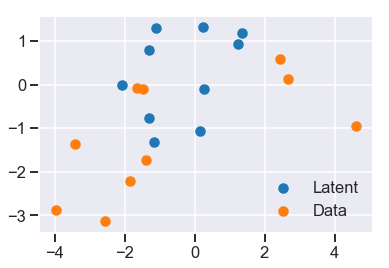

In [5]:
plt.scatter(x[:, 0], x[:, 1], label='Latent')
plt.scatter(y[:, 0], y[:, 1], label='Data')
plt.legend()
plt.show()

# 変分推論

In [6]:
model = LinearDimensionalityReduction(D, M, sigma_w, sigma_mu)
model.inference(y)

array([[ 2.43392587e+00, -2.92892419e+00],
       [ 2.70164654e+00, -2.58563355e+00],
       [ 6.17852795e-01, -5.06562208e-01],
       [ 5.07862517e-01, -2.95615086e-03],
       [-2.96785418e+00,  2.26630420e+00],
       [-2.35936612e+00,  2.69327848e+00],
       [ 1.84724903e+00, -1.85625732e+00],
       [ 1.26783503e+00, -1.32954175e+00],
       [-2.13850783e+00,  2.21748375e+00],
       [ 7.68541474e-01, -6.15596086e-01]])

# Irisデータに対する推論

In [47]:
X, y = load_iris(return_X_y=True)

In [48]:
X.shape, y.shape

((150, 4), (150,))

## 任意の二軸での図示

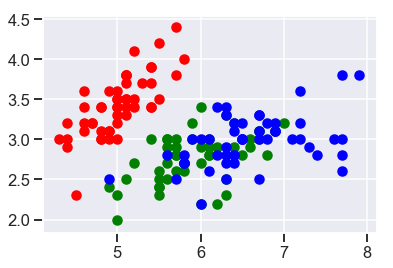

In [49]:
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.scatter(X[y == i, 0], X[y == i, 1], color=colors[i])
    
plt.show()

## 推論

In [52]:
D = 4  # Data
M = 2  # Latent
sigma_w = np.array([0.1 * np.eye(M)] * D)
sigma_mu = np.eye(D)
model = LinearDimensionalityReduction(D, M, sigma_w, sigma_mu)

# Inference
z_pred = model.inference(X)

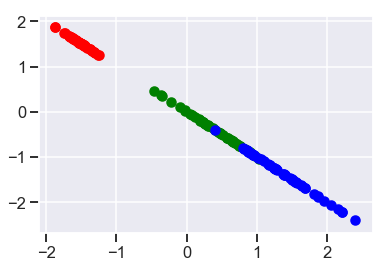

In [53]:
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.scatter(z_pred[y == i, 0], z_pred[y == i, 1], color=colors[i])
    
plt.show()

# Olivetti face

In [9]:
dataset = fetch_olivetti_faces(shuffle=True)

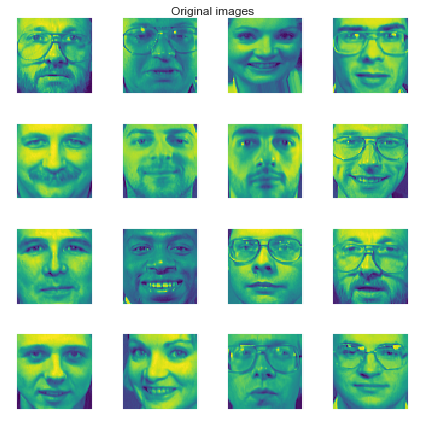

In [10]:
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(dataset['images'][i])
    plt.xticks([])
    plt.yticks([])

plt.suptitle('Original images')    
plt.tight_layout()
plt.show()

In [48]:
D = dataset['data'].shape[1]  # Data
M = 32  # Latent
sigma_w = np.array([0.1 * np.eye(M)] * D)
sigma_mu = np.eye(D)
model = LinearDimensionalityReduction(D, M, sigma_w, sigma_mu)

# Inference
z_pred = model.inference(dataset['data'])

潜在変数から画像を再構築する．

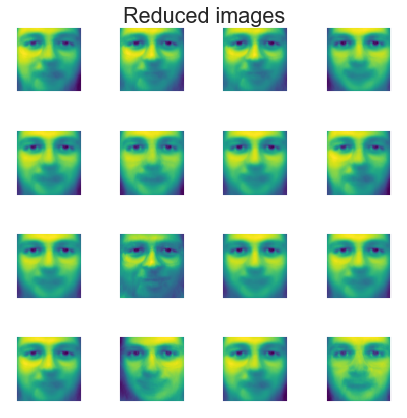

In [72]:
data_reduced = np.dot(z_pred, model.m_w_posterior) + model.m_mu_posterior
data_reduced = data_reduced.reshape((-1, 64, 64))

plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(data_reduced[i])
    plt.xticks([])
    plt.yticks([])

plt.suptitle('Reduced images')    
plt.tight_layout()
plt.show()

# 欠損値の補間

In [71]:
dataset = fetch_olivetti_faces(shuffle=True)

#### 各データについて，同じ次元のデータが損失していると仮定する．

In [126]:
missing_rate = 0.50
mask = rand(dataset['data'].shape[1]) < missing_rate
y_obs = deepcopy(dataset['data'])
y_obs[:, mask] = None

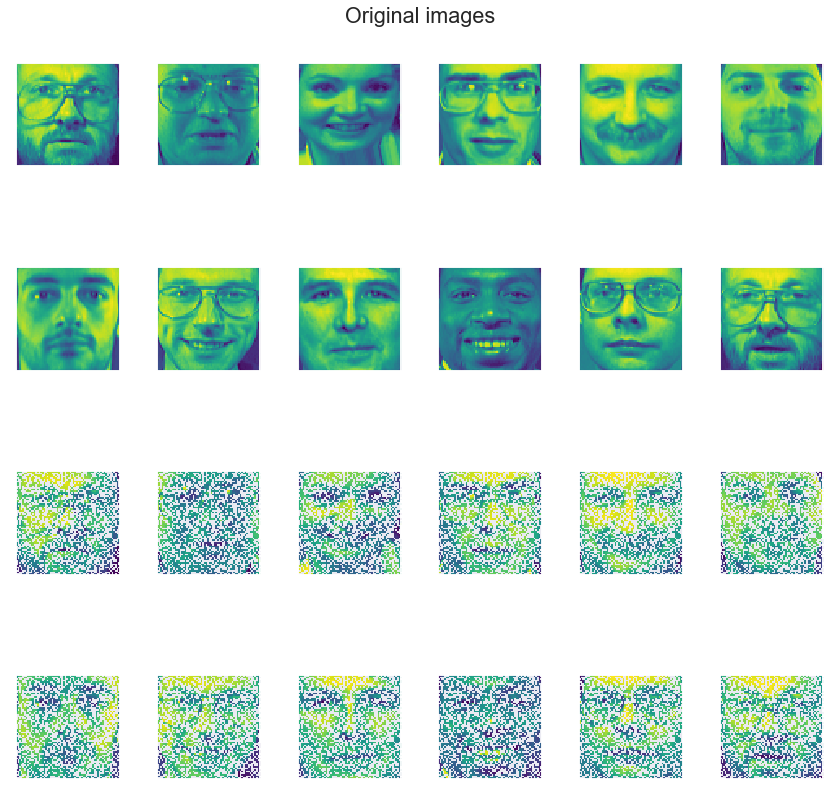

In [110]:
plt.figure(figsize=(12, 12))
for i in range(12):
    plt.subplot(4, 6, i + 1)
    plt.imshow(dataset['images'][i])
    plt.xticks([])
    plt.yticks([])
    
for i in range(12):
    plt.subplot(4, 6, i + 1 + 12)
    plt.imshow(y_obs[i].reshape((64, 64)))
    plt.xticks([])
    plt.yticks([])

plt.suptitle('Original images')    
plt.tight_layout()
plt.show()

In [111]:
D = dataset['data'].shape[1]  # Data
M = 32  # Latent
sigma_w = np.array([0.1 * np.eye(M)] * D)
sigma_mu = np.eye(D)
model = LinearDimensionalityReduction(D, M, sigma_w, sigma_mu)

# Inference
z_pred = model.inference(y_obs)

In [128]:
y_est = np.dot(z_pred, model.m_w_posterior) + model.m_mu_posterior
y_itp = deepcopy(y_obs)
y_itp[:, mask] = y_est[:, mask]

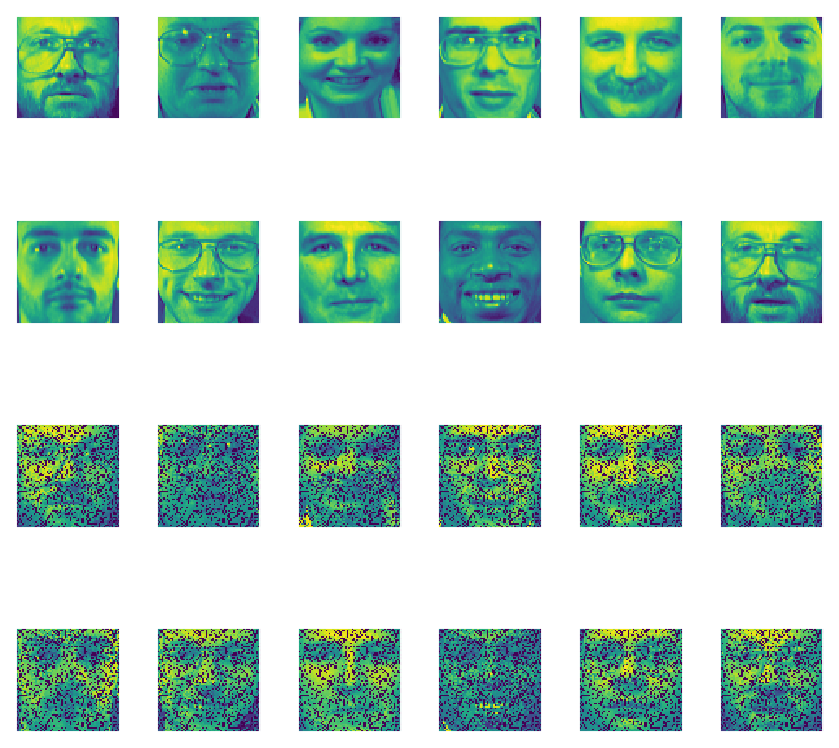

In [132]:
plt.figure(figsize=(12, 12))
for i in range(12):
    plt.subplot(4, 6, i + 1)
    plt.imshow(dataset['images'][i])
    plt.xticks([])
    plt.yticks([])
    
for i in range(12):
    plt.subplot(4, 6, i + 1 + 12)
    plt.imshow(y_itp[i].reshape((64, 64)))
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()